In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow import keras
from hyperopt import Trials, STATUS_OK, tpe
from hyperas.distributions import choice, uniform

2024-09-21 05:09:08.133370: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-21 05:09:08.943386: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-21 05:09:12.496928: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-21 05:09:12.502559: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-21 05:09:13.284590: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
input_dict = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'END': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12,
 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}

placeholder_index = 4

In [ ]:
def create_model(x_train, y_train, x_val, y_val, x_test, y_test):
    model = keras.models.Sequential([
        keras.layers.Input(shape=(x_train.shape[1],)),
        keras.layers.Embedding(input_dim=21, input_length=10, output_dim=50),

        keras.layers.LSTM(128, return_sequences=True, input_shape=(10,21)),
        keras.layers.Dropout({{uniform(0, 0.8)}}),

        keras.layers.LSTM(128, return_sequences=False),
        keras.layers.Dropout({{uniform(0, 0.8)}}),

        keras.layers.Dense(64),
        keras.layers.LeakyReLU(alpha={{uniform(0, 0.8)}}),

        keras.layers.Dropout({{uniform(0, 0.8)}}),
        keras.layers.Dense(1)
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate={{choice([0.001, 0.005, 0.01, 0.05, 0.1])}}), loss='mean_squared_error', metrics=['mse'])

    result = model.fit(x_train, y_train, validation_split=0.3, epochs=200, batch_size={{choice([32, 64, 128, 5000])}}, verbose=2)

    mse = np.amax(result.history['val_mse']) 
    print('Best validation acc of epoch:', mse)
    return {'loss': -mse, 'status': STATUS_OK, 'model': model}

def data():
    x_train = pd.read_table('Data/20210524_A1101_xtrain.txt', sep=' ', header=None)
    y_train = pd.read_table('Data/20210524_A1101_ytrain.txt', sep=' ', header=None)
    x_val = pd.read_table('Data/20210524_A1101_xval.txt', sep=' ', header=None)
    y_val = pd.read_table('Data/20210524_A1101_yval.txt', sep=' ', header=None)
    x_test = pd.read_table('Data/20210524_A1101_xtest.txt', sep=' ', header=None)
    y_test = pd.read_table('Data/20210524_A1101_ytest.txt', sep=' ', header=None)
    return x_train, y_train, x_val, y_val, x_test, y_test
    

In [4]:
x_train = pd.read_table('Data/20201230_all5_xtrain.txt', sep=' ', header=None)
y_train = pd.read_table('Data/20201230_all5_ytrain.txt', sep=' ', header=None)
x_val = pd.read_table('Data/20201230_all5_xval.txt', sep=' ', header=None)
y_val = pd.read_table('Data/20201230_all5_yval.txt', sep=' ', header=None)
x_test = pd.read_table('Data/20201230_all5_xtest.txt', sep=' ', header=None)
y_test = pd.read_table('Data/20201230_all5_ytest.txt', sep=' ', header=None)

In [ ]:
import keras_tuner as kt

class Mamu(kt.HyperModel):
    def build(self, hp):
        model = keras.models.Sequential([
            keras.layers.Input(shape=(x_train.shape[1],)),
            keras.layers.Embedding(input_dim=21, input_length=10, output_dim=50),

            keras.layers.LSTM(128, return_sequences=True, input_shape=(10,21)),
            keras.layers.Dropout(hp.Float('dropout_1', 0, 0.6, step=0.00005)),

            keras.layers.LSTM(128, return_sequences=False),
            keras.layers.Dropout(hp.Float('dropout_2', 0, 0.6, step=0.00005)),

            keras.layers.Dense(64),
            keras.layers.LeakyReLU(alpha=hp.Float('alpha_leaky', 0, 0.6, step=0.00005)),

            keras.layers.Dropout(hp.Float('dropout_3', 0, 0.6, step=0.00005)),
            keras.layers.Dense(5)
        ])

        model.compile(
            optimizer=keras.optimizers.Adam(0.001),
            loss='mean_squared_error',
            metrics=['mse']
        )

        return model
    
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice('batch_size', [32, 64, 128, 5000]),
            **kwargs
        )


In [ ]:
tuner = kt.Hyperband(
    Mamu(),
    objective='val_mse',
    max_epochs=100,
    factor=3,
    directory='tuner',
    project_name='Mamu_tuner'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
tuner.search(x_train, y_train, epochs=2000, validation_split=0.2, validation_data = (x_val, y_val), callbacks=[stop_early])

In [ ]:
model = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])

In [ ]:
history = model.fit(x_train, y_train, epochs=2000, validation_data=(x_val, y_val))

In [ ]:
plt.plot(range(2000) ,history.history['loss'], label='loss')
plt.plot(range(2000), history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 0.1])
plt.xlim([0, 250])
plt.legend(loc='best')
plt.show()

In [ ]:
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
tuner.get_best_hyperparameters()[0].values

In [ ]:
model = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])
model.fit(x_train, y_train, epochs=best_epoch, validation_data=(x_val, y_val))

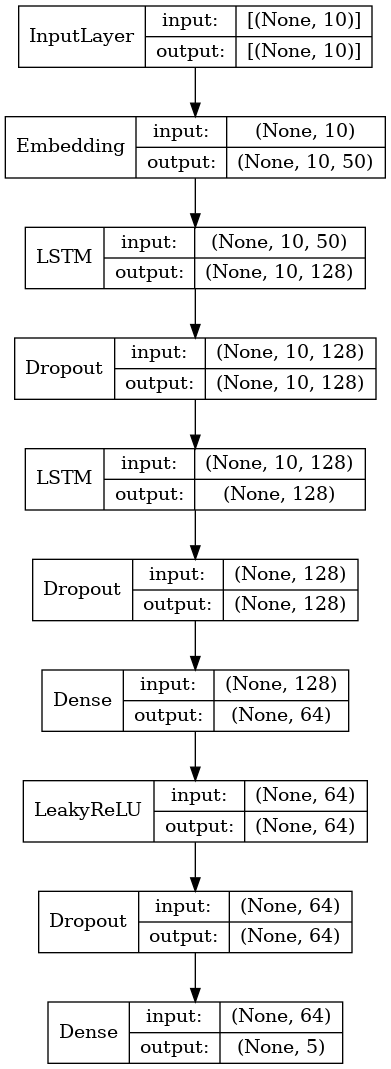

In [20]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
eval_result = model.evaluate(x_test, y_test)
print("[test loss, test mse]:", eval_result)

In [21]:
y_pred = model.predict(x_test)
y_pred = pd.DataFrame(y_pred)
new_y_test = pd.DataFrame(y_test)

193/193 [==============================] - 4s 9ms/step


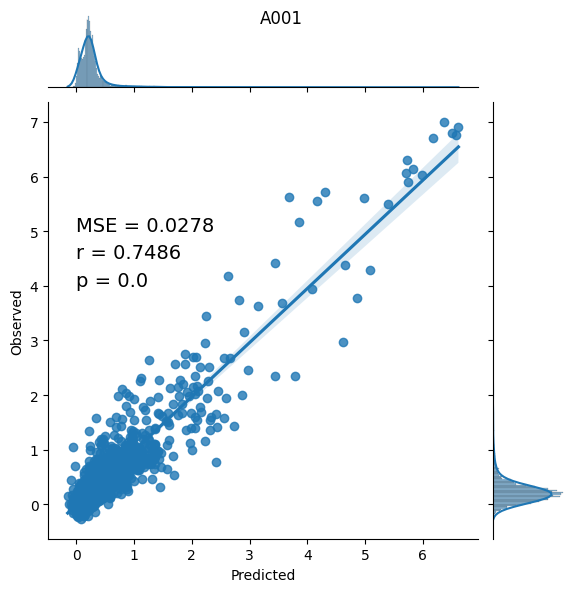

In [23]:
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error

intensity = 0

jp = sns.jointplot(x=y_pred.iloc[:, intensity], y=new_y_test.iloc[:, intensity], kind='reg')
jp.fig.suptitle('A001')
jp.ax_joint.set_xlabel('Predicted')
jp.ax_joint.set_ylabel('Observed')
prCor, pCor = spearmanr(y_pred.iloc[:, intensity], new_y_test.iloc[:, intensity])
mse = round(mean_squared_error(y_pred.iloc[:, intensity], new_y_test.iloc[:, intensity]),4)
jp.ax_joint.text(0,5,"MSE = " + str(mse), fontsize=14)
jp.ax_joint.text(0,4.5,"r = " + str(round(prCor,4)), fontsize=14)
jp.ax_joint.text(0,4,"p = " + str(pCor), fontsize=14)

# # Set the figure size
# jp.figure.set_size_inches(0.001, 0.25)

plt.show()

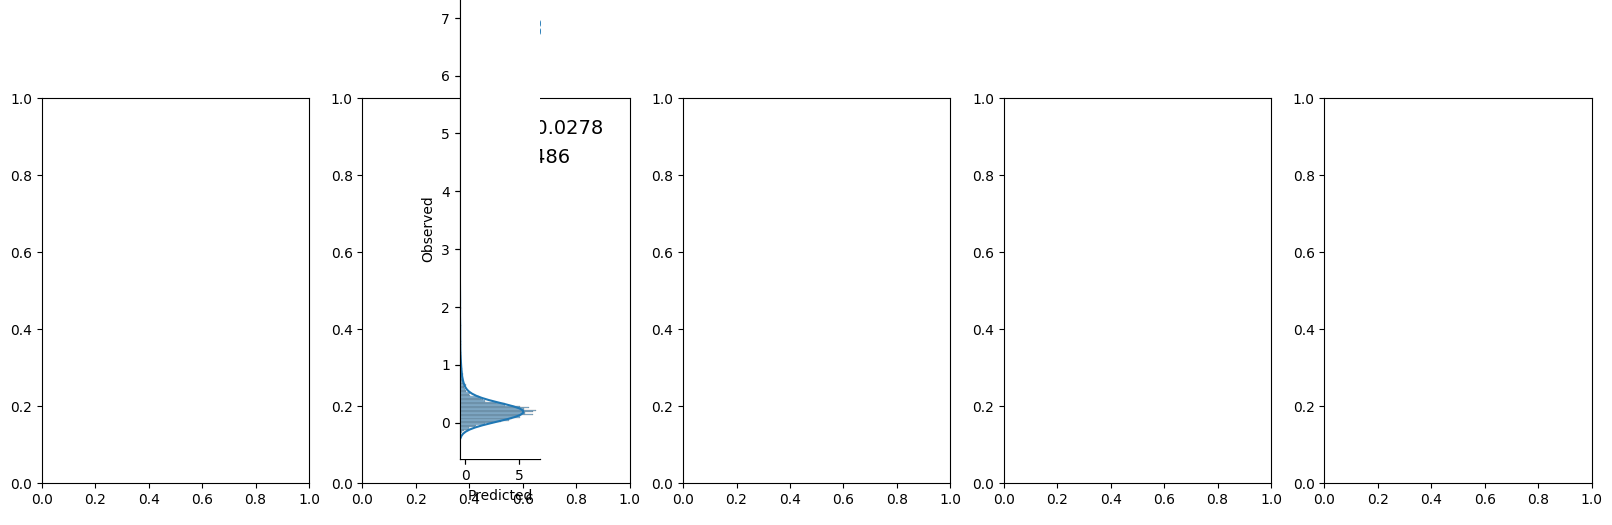

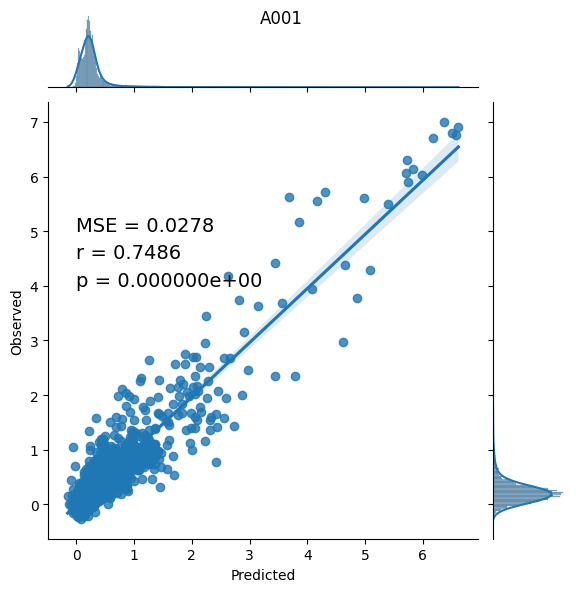

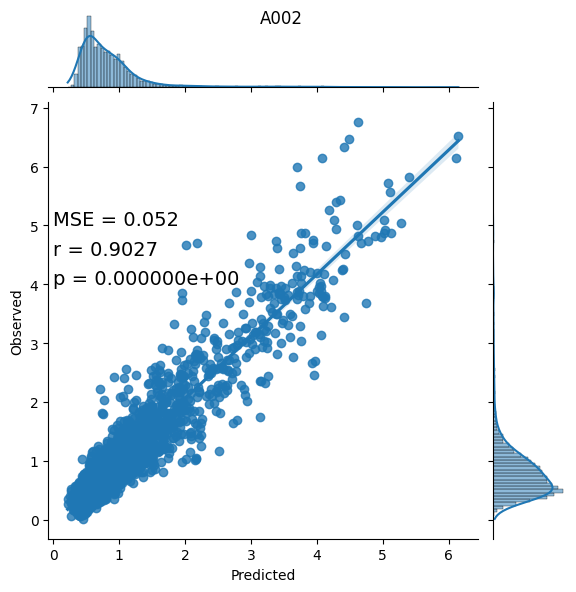

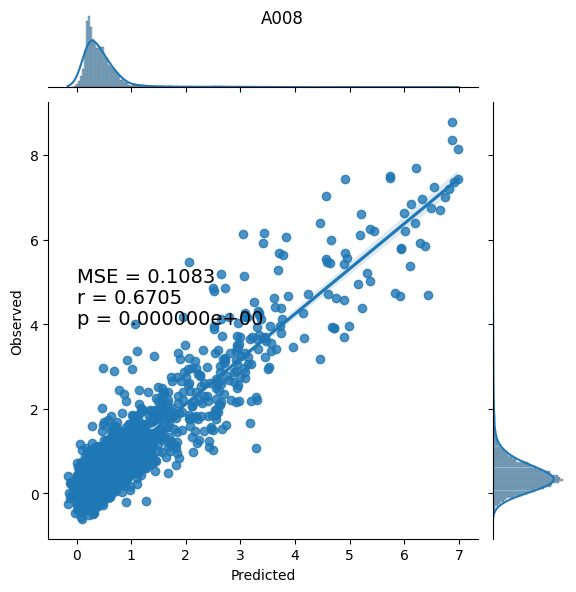

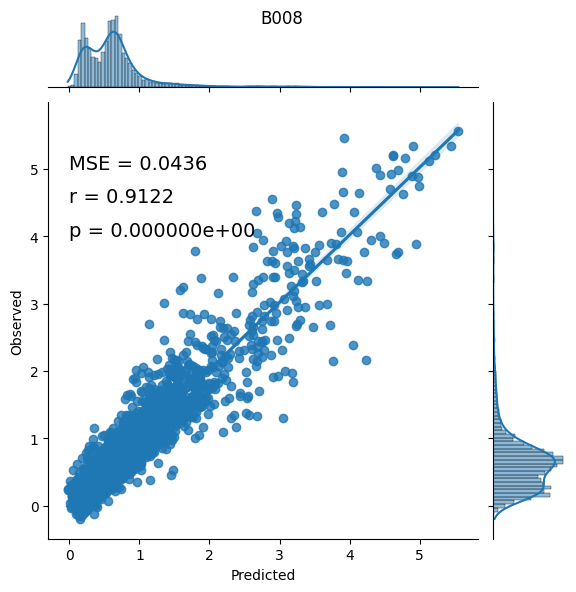

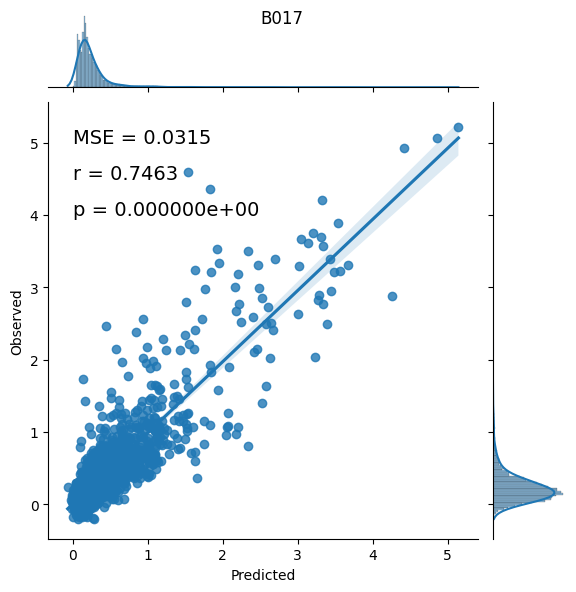

In [24]:
plots = []
title = ['A001', 'A002', 'A008', 'B008', 'B017']

fig, axes = plt.subplots(1, len(title), figsize=(20, 5))

for intensity in range(5):
    plots.append(sns.jointplot(x=y_pred.iloc[:, intensity], y=new_y_test.iloc[:, intensity], kind='reg'))
    plots[intensity].fig.suptitle(title[intensity])
    plots[intensity].ax_joint.set_xlabel('Predicted')
    plots[intensity].ax_joint.set_ylabel('Observed')
    prCor, pCor = spearmanr(y_pred.iloc[:, intensity], new_y_test.iloc[:, intensity])
    mse = round(mean_squared_error(y_pred.iloc[:, intensity], new_y_test.iloc[:, intensity]),4)
    plots[intensity].ax_joint.text(0,5,"MSE = " + str(mse), fontsize=14)
    plots[intensity].ax_joint.text(0,4.5,"r = " + str(round(prCor,4)), fontsize=14)
    plots[intensity].ax_joint.text(0,4,"p = " + "{:e}".format(pCor), fontsize=14)

    for A in jp.fig.axes:
        A.figure = fig
        fig.axes.append(A)
        fig.add_axes(A)
        A.set_position(axes[intensity].get_position())
    plt.savefig('Images/1_LSTM_Mamu_'+ title[intensity] +'_perf.png')

plt.show()

In [5]:
import shap
shap.initjs()

In [63]:
samp = shap.kmeans(x_train, 100)
explainer = shap.KernelExplainer(model.predict, samp)
# shape_values = explainer.shap_values(X=x_test, nsamples=298)

4/4 [==============================] - 1s 7ms/step


In [9]:
np.save('Reg_SHAP/Mamu_shap_values.npy', shape_values)

In [ ]:
# Init pos array (4d)
pos = [[[[0.0 for _ in range(5)], 0] for _ in range(21)] for _ in range(10)]

# Start browsing through SHAP value
for i in range(x_test.shape[0]):
    input_array = [list(input_dict.keys())[int(key)] for key in x_test.iloc[i]]
    print(''.join([value if value != "END" else "" for value in input_array]))
    shap_values_single = explainer.shap_values(X=x_test.iloc[i : i + 1, :], nsamples=100)
    pos_index = 0
    for value in shap_values_single[0]:
        for index, intensity_value in enumerate(value):
            pos[pos_index][input_dict.get(input_array[pos_index])][0][index] += value[index]
        pos[pos_index][input_dict.get(input_array[pos_index])][1] += 1
        pos_index += 1

# Saving model + poshap

In [ ]:
model.save('Model/Mamu_model')
new_pos = pd.DataFrame(pos).to_numpy()
np.save('Poshap/Mamu_poshap', new_pos)

# Test load model

In [6]:
model = keras.models.load_model('Model/Mamu_model')
pos = np.load('Poshap/Mamu_poshap.npy', allow_pickle=True)

In [26]:
shap_values = np.load('Reg_SHAP/Mamu_shap_values.npy')

In [94]:
count_mamu = [[value[1] for value in pos[i]] for i in range(10)]
poshap_a001 = [[value[0][0]/(value[1] if value[1] != 0 else 1) for value in pos[i]] for i in range(10)]
poshap_a002 = [[value[0][1]/(value[1] if value[1] != 0 else 1) for value in pos[i]] for i in range(10)]
poshap_a008 = [[value[0][2]/(value[1] if value[1] != 0 else 1) for value in pos[i]] for i in range(10)]
poshap_b008 = [[value[0][3]/(value[1] if value[1] != 0 else 1) for value in pos[i]] for i in range(10)]
poshap_b017 = [[value[0][4]/(value[1] if value[1] != 0 else 1) for value in pos[i]] for i in range(10)]

list_poshap = [poshap_a001, poshap_a002, poshap_a008, poshap_b008, poshap_b017]

In [ ]:
plt.figure(figsize=(15, 6))
ax = sns.heatmap(count_mamu, cmap='viridis', center=0, annot=True, fmt= 'd',)

current_labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [list(input_dict.keys())[int(label)] for label in current_labels]
ax.set_xticklabels(new_labels)

plt.show()

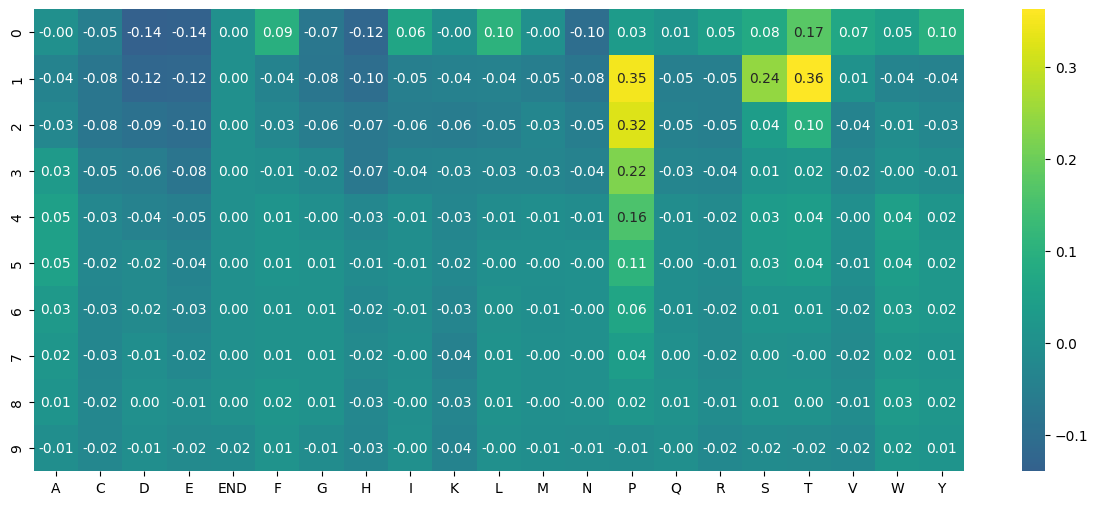

In [50]:
plt.figure(figsize=(15, 6))
ax = sns.heatmap(poshap_a001, cmap='viridis', center=0, annot=True, fmt= '.2f',)

current_labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [list(input_dict.keys())[int(label)] for label in current_labels]
ax.set_xticklabels(new_labels)
ax.set_yticklabels()

plt.show()

In [61]:
top_y_pred_index = np.argmax(y_pred[0])
top_y_pred_index

3536

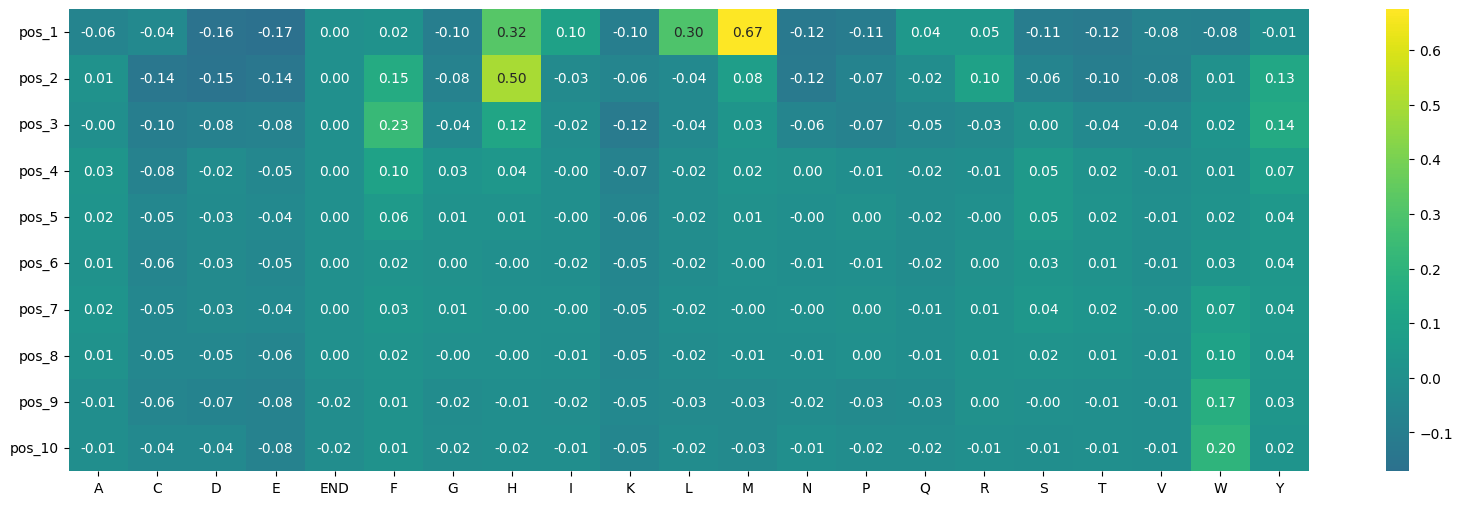

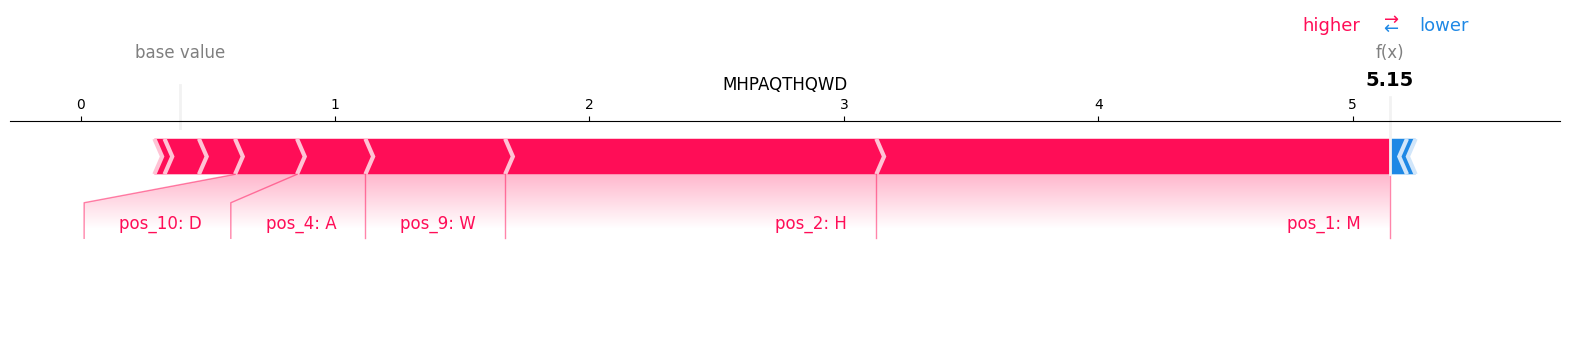

In [90]:
plt.figure(figsize=(20, 6))

intensity = 4

# Heatmap
ax = sns.heatmap(poshap_b017, cmap='viridis', center=0, annot=True, fmt= '.2f',)
current_labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [list(input_dict.keys())[int(label)] for label in current_labels]
ax.set_xticklabels(new_labels)
ax.set_yticklabels(['pos_' + str(i+1) for i in range(10)])
ax.yaxis.set_tick_params(rotation=0)

# Top predicted force_plot
top_y_pred_index = np.argmax(y_pred[intensity])
input_seq = [list(input_dict.keys())[int(key)] for key in x_test.iloc[top_y_pred_index].values]
feature_names_with_values = [
    f'pos_{i+1}: {input_seq[i]}' for i in range(len(input_seq))
]
shap.force_plot(
    base_value=explainer.expected_value[intensity],
    shap_values=shap_values[top_y_pred_index][:, intensity],
    features=input_seq,
    feature_names=feature_names_with_values,
    show=False,
    matplotlib=True
)
ax2 = plt.gca()
ax2.set_title(''.join([value if value != "END" else "" for value in input_seq]))

plt.show()

<Figure size 2000x600 with 0 Axes>

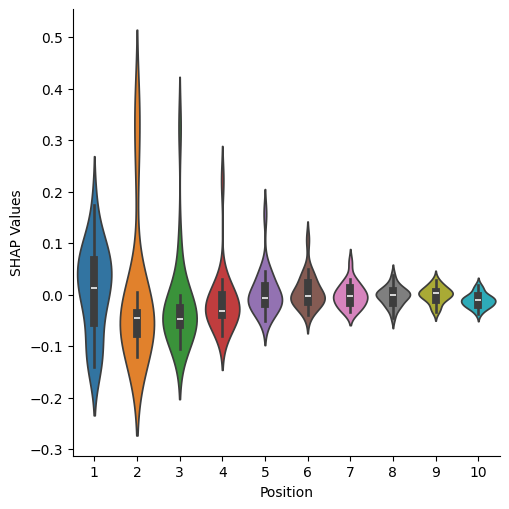

In [132]:
intensity = 0

plt.figure(figsize=(20,6))
ax = sns.catplot(data=list_poshap[intensity], kind='violin')
ax.set_xlabels('Position')
ax.set_ylabels('SHAP Values')
ax.set_xticklabels([str(i+1) for i in range(10)])

plt.savefig('Images/6_Mamu_' + title[intensity] + '_catplot.png')
plt.show()

In [127]:
np.array(list_poshap[intensity])[0]

array([-0.00077288, -0.05443234, -0.13989642, -0.13559499,  0.        ,
        0.09380451, -0.07379364, -0.12118576,  0.06358371, -0.00492956,
        0.10495467, -0.00138528, -0.10185653,  0.03206164,  0.0138402 ,
        0.04505108,  0.07520138,  0.17479788,  0.06826657,  0.04635639,
        0.09607987])

In [ ]:
for intensity in range(5):

    plt.figure(figsize=(20,6))
    ax = sns.catplot(data=np.array(list_poshap[intensity]), kind='violin')
    ax.set_xlabels('Amino Acids')
    ax.set_ylabels('SHAP Values')
    ax.set_xticklabels([list(input_dict.keys())[int(key)] for key in range(21)])

    plt.savefig('Images/7_Mamu_' + title[intensity] + '_AA_catplot.png')
    plt.show()

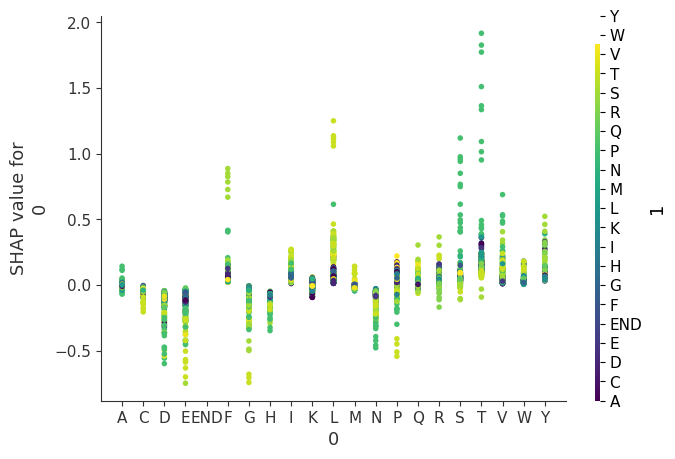

In [31]:
import matplotlib.cm as cm
shap.dependence_plot(0, shap_values[:, : , 0], x_test.iloc[:,:], interaction_index=1 ,show=False, x)
fig, ax = plt.gcf(), plt.gca()
ax.set_xticks(range(len(input_dict.keys())))
ax.set_xticklabels(list(input_dict.keys()))

for collection in ax.collections:
    collection.set_cmap(cm.viridis) 

cbar = ax.figure.axes[1]
cbar.set_yticks(range(len(input_dict.keys())))
cbar.set_yticklabels(list(input_dict.keys()))
plt.show()

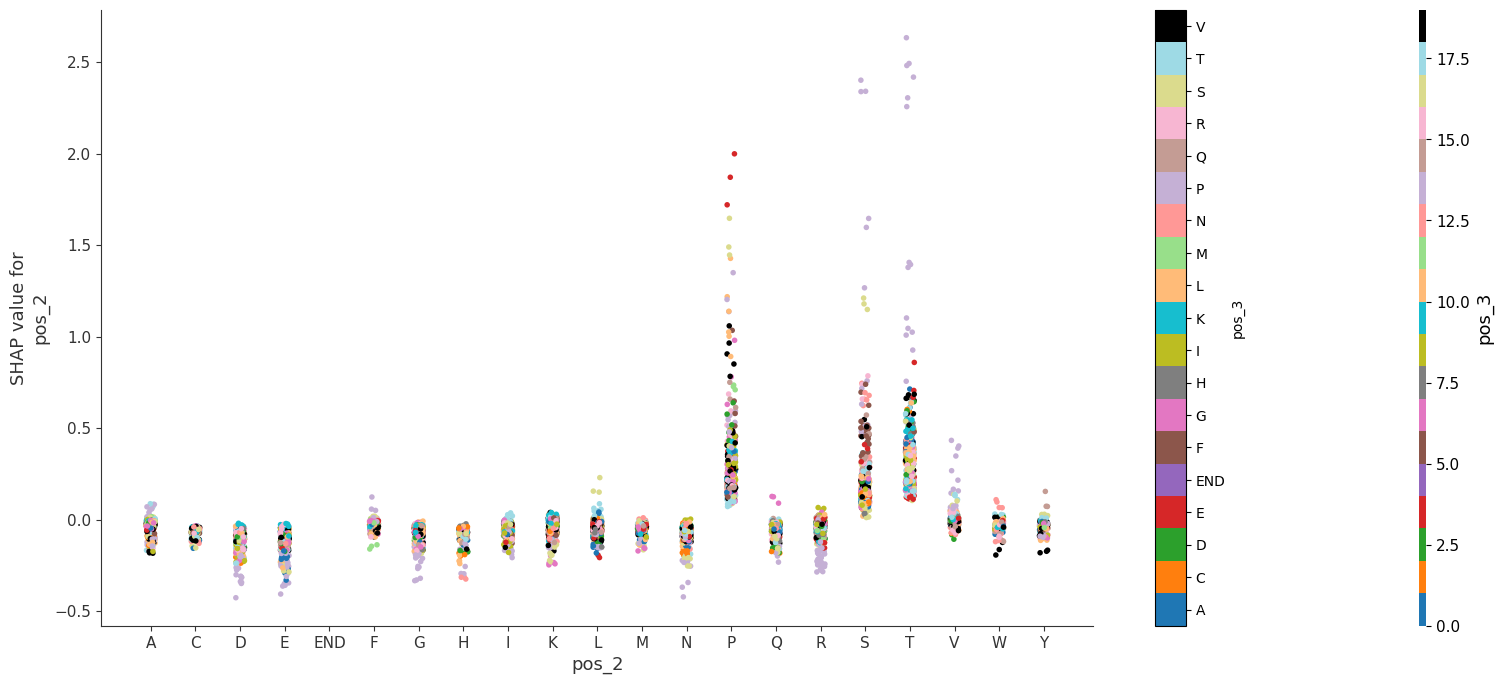

In [153]:
import matplotlib.cm as cm
import numpy as np
import matplotlib.colors as mcolors

base = 1
interactions = 2

colors =  [
    "#1f77b4",  # Blue
    "#ff7f0e",  # Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#8c564b",  # Brown
    "#e377c2",  # Pink
    "#7f7f7f",  # Gray
    "#bcbd22",  # Olive
    "#17becf",  # Cyan
    "#ffbb78",  # Light Orange
    "#98df8a",  # Light Green
    "#ff9896",  # Light Red
    "#c5b0d5",  # Light Purple
    "#c49c94",  # Light Brown
    "#f7b6d2",  # Light Pink
    "#dbdb8d",  # Light Olive
    "#9edae5",  # Light Cyan
    "#000000",  # Black
    "#7f7f7f",  # Dark Gray
    "#ffddc1"   # Very Light Orange
]
# colors.reverse()
custom_cmap = mcolors.ListedColormap(colors[:y_max])

fig, ax = plt.subplots(figsize=(20, 8))
shap.dependence_plot(base, shap_values[:, : , 0], x_test.iloc[:,:], interaction_index=interactions, ax = ax, x_jitter=0.2, show=False, cmap=custom_cmap, feature_names=['pos_' + str(i + 1) for i in range(10)])
ax.set_xticks(range(len(input_dict.keys())))
ax.set_xticklabels(list(input_dict.keys()))

cbar = ax.figure.axes[1]
y_max = round(cbar.get_ylim()[1])
# cbar.set_yticks(range(0, len(input_dict.keys()) - 2))
# cbar.ticklabel_format(axis='y', useOffset=False)
# cbar.set_yticklabels(list(input_dict.keys()))
# cbar.set_ylim(0.5, (len(input_dict.keys()) + 0.5))
# cbar.clear()
# cbar.set_axis_off()

norm = mcolors.BoundaryNorm(boundaries=np.arange(y_max + 1) - 0.5, ncolors=y_max)
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=custom_cmap), ax=ax, orientation='vertical')
cbar.set_ticks(range(y_max))
cbar.set_ticklabels(list(input_dict.keys())[:y_max])
cbar.minorticks_off()
cbar.set_label('pos_' + str(interactions + 1))

plt.show()

In [145]:
input_dict

{'A': 0,
 'C': 1,
 'D': 2,
 'E': 3,
 'END': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'K': 9,
 'L': 10,
 'M': 11,
 'N': 12,
 'P': 13,
 'Q': 14,
 'R': 15,
 'S': 16,
 'T': 17,
 'V': 18,
 'W': 19,
 'Y': 20}

In [8]:
# Dependency analysis


# Divide 2 group

first_aa = [[[[[] for _ in range(10)] for _ in range(21)] for _ in range(21)] for _ in range(10)]
compare_aa = [[[[[] for _ in range(10)] for _ in range(21)] for _ in range(21)] for _ in range(10)]

for f_pos in range(10):
    for f_aa in range(21):
        if f_aa != placeholder_index:   
            for c_pos in range(10):
                if f_pos != c_pos:
                    for c_aa in range(21):
                        if c_aa != placeholder_index:
                            for i in range(x_test.shape[0]):
                                if x_test.iloc[i, f_pos] == f_aa and x_test.iloc[i, c_pos] == c_aa:
                                    first_aa[f_pos][f_aa][c_aa][c_pos].append(shap_values[i, f_pos, 0])
                                if x_test.iloc[i, f_pos] == f_aa and x_test.iloc[i, c_pos] != c_aa:
                                    compare_aa[f_pos][f_aa][c_aa][c_pos].append(shap_values[i, f_pos, 0])
                        

In [9]:
np.save('Dep/Mamu_firstdep.npy', pd.DataFrame(first_aa).to_numpy())
np.save('Dep/Mamu_comdep.npy', pd.DataFrame(compare_aa).to_numpy())

In [16]:
from scipy.stats import mannwhitneyu

output = []

for f_pos in range(len(first_aa)):
    for f_aa in range(len(first_aa[f_pos])):
        for c_aa in range(len(first_aa[f_pos][f_aa])):
            for c_pos in range(len(first_aa[f_pos][f_aa][c_aa])):
                try:
                    stat, test = mannwhitneyu(first_aa[f_pos][f_aa][c_aa][c_pos], compare_aa[f_pos][f_aa][c_aa][c_pos])
                except ValueError:
                    stat = 1
                    test = 1
                if test < 1 and test > 0:
                    output.append([test, list(input_dict.keys())[f_aa], f_pos + 1, c_pos + 1, list(input_dict.keys())[c_aa], len(first_aa[f_pos][f_aa][c_aa][c_pos]), len(compare_aa[f_pos][f_aa][c_aa][c_pos])])
                    


/tmp/ipykernel_1265/2043924547.py:10: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, test = mannwhitneyu(first_aa[f_pos][f_aa][c_aa][c_pos], compare_aa[f_pos][f_aa][c_aa][c_pos])


In [17]:
output = pd.DataFrame(output, columns=['p-val', 'aa', 'pos', 'compare aa', 'compare pos', 'compare size', 'total size'])

In [18]:
from statsmodels.stats import multitest
corr_pval = multitest.multipletests(output['p-val'].tolist(), alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)
output.insert(1, 'corr p-val', corr_pval[1])
output

,p-val,corr p-val,aa,pos,compare aa,compare pos,compare size,total size
0,0.942876,1.0,A,1,2,A,18,304
1,0.000042,1.0,A,1,3,A,36,286
2,0.325722,1.0,A,1,4,A,15,307
3,0.807006,1.0,A,1,5,A,20,302
4,0.001589,1.0,A,1,6,A,33,289
...,...,...,...,...,...,...,...,...
33088,0.925405,1.0,Y,10,5,Y,4,60
33089,0.237762,1.0,Y,10,6,Y,4,60
33090,0.142265,1.0,Y,10,7,Y,4,60
33091,0.218750,1.0,Y,10,8,Y,1,63


In [19]:
output_below = output.loc[output['corr p-val'] <= 0.05]
output_below.sort_values(by='corr p-val', ascending=True)
output_below.to_csv('mamu_de.csv')